Here is the solution to my relax takehome challenge. 

We start by importing the necessary libaries and importing the csvs

In [478]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
%matplotlib inline

In [470]:
df = pd.read_csv("takehome_user_engagement.csv")

In [471]:
users = pd.read_csv("takehome_users.csv", encoding='latin-1')

We then look at the head of our two dataframes so that we know what we're dealing with

In [472]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [473]:
df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


We then check the datatype of the time_stamp variable

In [474]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


We then convert the time_stamp variable to a datetime, this makes the variable much easier to work with since we can use pandas grouper function to group the visits by week. We then group our engagement dataframe (df) by user_id and count the number of times they visited the site per week

In [431]:
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
df = df.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W')])['visited'].sum()
df = pd.DataFrame(df)

We then create a list of users who visited the website three or more times in a given week

In [432]:
df = df['visited'].loc[df['visited']>2]
df = pd.DataFrame(df)
df = df.reset_index()
engage = df['user_id']
engage = list(set(engage))

We then create a feature in our users dataframe which tells us if the customer was 'engaged' i.e. they visited the website three or more times in a week

In [433]:
users['engage'] = users['object_id'].isin(engage)
users['engage'] = users['engage'].astype(int)

We then use a label encoder to convert some of the non-numeric features to numeric so that we can use them then are easier to deal with

In [434]:
lb_make = LabelEncoder()
categories = ['creation_source', 'last_session_creation_time', 'invited_by_user_id']
for col in categories: 
    users[col] = lb_make.fit_transform(users[col])

We are now going to train a decision tree to predict whether or not a user will become engaged, we create a list of features we want to look at and call it X, we also have our target variable y which is a binary variable which tells us whether or not the customer was engaged

In [454]:
features = ['creation_source','last_session_creation_time','opted_in_to_mailing_list','enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'org_id']
X = users[features]
y = users['engage']

We then split the data into a test train split and fit the training data to the decision tree

In [455]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

We then use the trained decision tree to predict the outcome of the testing data. We evaluate the model using a confusion matrix

In [456]:
predictions = dtree.predict(X_test)
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.94      0.93      0.94      2108
          1       0.54      0.60      0.57       292

avg / total       0.89      0.89      0.89      2400



We can see that the decision tree did a resonable job of predicting the outcome. We will now look at each of the features to see how important they are in predicting the final result

In [457]:
d = {'feature': features, 'importance': dtree.feature_importances_}
df_feat = pd.DataFrame(data=d)

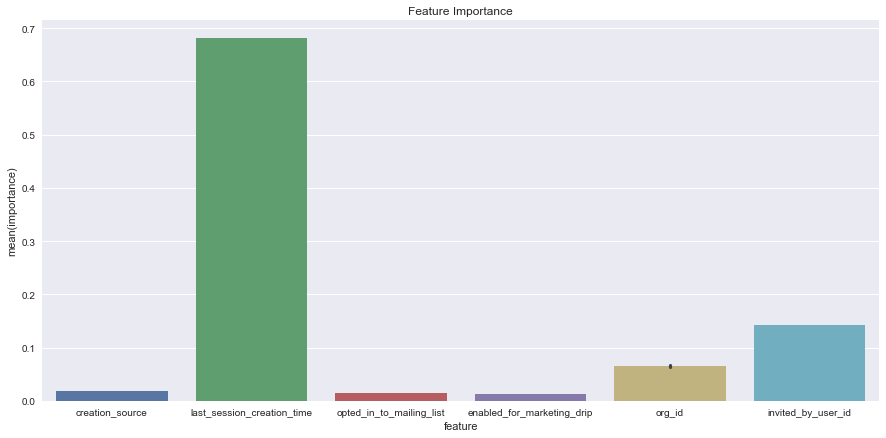

In [479]:
fig, ax = pyplot.subplots(figsize=(15,7))
sns.barplot(x='feature', y='importance', data=df_feat)
plt.title('Feature Importance')

From the graph we can see that the last session creation time is by far the strongest predictor of whether or not the user wil become engaged, the user who invited them and the org_id are also mildly predictive